# Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1
Write a function that samples a discrete random variable. You will use this to implement Step 1 of the boosting algorithm given above. The function should take in a positive integer n and a k-dimensional probability distribution w. It should return a 1 × n vector c, where each $ci ∈ {1, . . . , k}$
and $Prob(ci = j|w) = w(j)$. The entries of c should be independently generated. For the distribution $w = [0.1, 0.2, 0.3, 0.4]$, show the histogram of one sampled vector c when $n = 50, 250, 500$.

Hint: The cumulative distribution function (CDF) of w, and n uniform random variables will be useful.

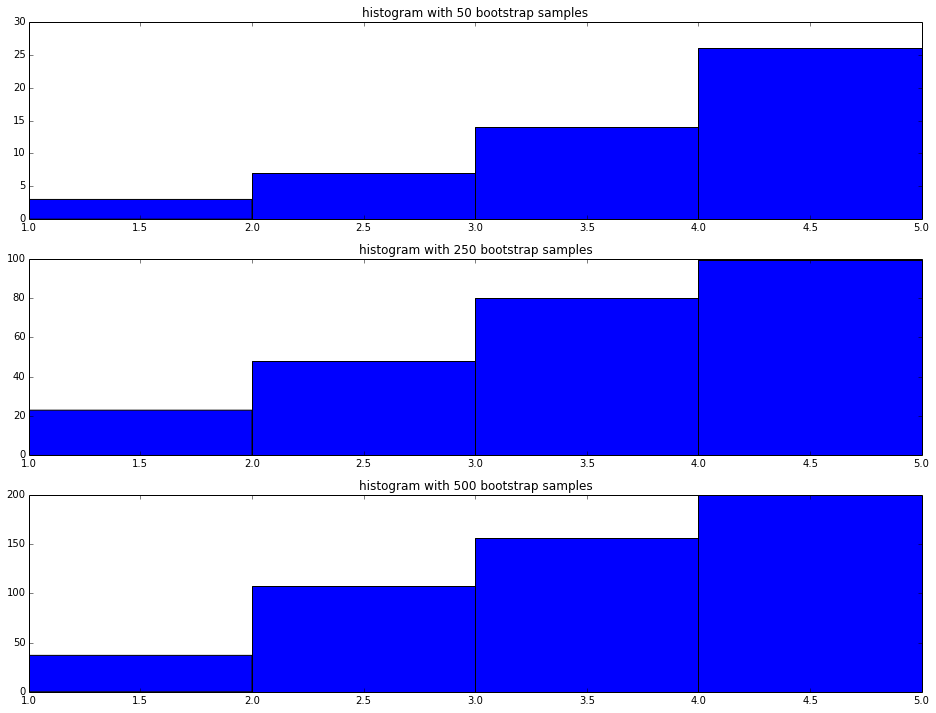

In [76]:
def discrete_random(n, w):
    values = np.arange(1, len(w)+1)
    bins = np.add.accumulate(w)
    return values[np.digitize(np.random.random_sample(n), bins)]
    
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12
plt.subplot(3, 1, 1)
plt.hist(discrete_random(50, [0.1,0.2,0.3,0.4]), bins=bin_edges)
plt.title('histogram with 50 bootstrap samples')
plt.subplot(3, 1, 2)
plt.hist(discrete_random(250, [0.1,0.2,0.3,0.4]), bins=bin_edges)
plt.title('histogram with 250 bootstrap samples')
plt.subplot(3, 1, 3)
plt.hist(discrete_random(500, [0.1,0.2,0.3,0.4]), bins=bin_edges)
plt.title('histogram with 500 bootstrap samples')
plt.show()

# Implementing AdaBoost

In [44]:
class AdaBoost(object):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
        self.estimators_ = []
        self.alpha = []
        self.epsilon = []
    
    def fit(self, X, y, iterations=1000):
        self.alpha = []
        self.epsilon = []
        self.estimators_ = []
        p = []
        p.append(np.full(X.shape[0], 1.0/X.shape[0]))
        for t in xrange(iterations):
            sample_ind = np.random.choice(X.shape[0], X.shape[0], p=p[-1])
            X_sample = X[sample_ind, :]
            y_sample = y[sample_ind]
            model = self.base_estimator()
            model.fit(X_sample, y_sample)
            y_test = model.predict(X)
            self.epsilon.append(0.0)
            for i in xrange(X.shape[0]):
                if y[i] != y_test[i]:
                    self.epsilon[-1] += p[-1][i]
            self.alpha.append(np.log(1/self.epsilon[-1] - 1) / 2)
            p_to_append = []
            for i in xrange(X.shape[0]):
                p_to_append.append(p[-1][i] * np.exp(-self.alpha[-1] * y[i] * y_test[i]))
            p_to_append = np.array(p_to_append)
            p_to_append /= p_to_append.sum()
            p.append(p_to_append); self.estimators_.append(model)
        return np.array(p)
    
    def predict(self, X):
        y = np.zeros(X.shape[0])
        for ind, model in enumerate(self.estimators_):
            y += self.alpha[ind] * model.predict(X)
        return np.sign(y)

# Implement Bayes Classifier with Shared Covariance

In [43]:
class Bayes(object):
    def __init__(self):
        self.w, self.w_0 = None, 0.
    
    def fit(self, X, y):
        mu_neg = np.zeros(X.shape[1])
        mu_pos = np.zeros(X.shape[1])
        pi_neg = 0.; pi_pos = 0.
        for i in range(y.size):
            if y[i] > 0:
                pi_pos += 1; mu_pos += X[i, :]
            else:
                pi_neg += 1; mu_neg += X[i, :]
        mu_pos /= pi_pos; mu_neg /= pi_neg
        var_pos = np.zeros((X.shape[1], X.shape[1])); var_neg = np.zeros((X.shape[1], X.shape[1]))
        for i in range(y.size):
            if y[i] > 0:
                var_pos += np.dot((X[i, :]-mu_pos)[np.newaxis].T, (X[i, :]-mu_pos)[np.newaxis])
            else:
                var_neg += np.dot((X[i, :]-mu_neg)[np.newaxis].T, (X[i, :]-mu_neg)[np.newaxis])
        var_pos /= pi_pos; var_neg /= pi_neg
        covariance = (mu_pos*var_pos + mu_neg*var_neg) / (mu_pos+mu_neg)
        self.w_0 = np.log(pi_pos/pi_neg) - np.dot((mu_pos+mu_neg)[np.newaxis], \
               np.dot(np.linalg.inv(covariance), (mu_pos-mu_neg)[np.newaxis].T))/2
        self.w = np.dot(np.linalg.inv(covariance), (mu_pos-mu_neg)[np.newaxis].T)
    
    def predict(self, X):
        return np.ravel(np.sign(self.w_0 + np.dot(X, self.w)))

# Implementing Tests Scheme

In [48]:
def tests(X_train, y_train, X_test, y_test, model):
    from sklearn.metrics import accuracy_score
    AB = AdaBoost(model)
    probs = AB.fit(X_train, y_train)
    y_predict = AB.predict(X_test)
    print("Accuary with AdaBoost wrapped is {}.".format(accuracy_score(y_test, y_predict)))
    %matplotlib inline
    import matplotlib.pylab as pylab
    pylab.rcParams['figure.figsize'] = 16, 12
    plt.subplot(3, 1, 1)
    plt.plot(np.array(AB.alpha))
    plt.title('evolution of $alpha$')
    plt.subplot(3, 1, 2)
    plt.plot(np.array(AB.epsilon))
    plt.title('evolution of $\epsilon$')
    plt.subplot(3, 1, 3)
    choose = np.random.randint(0, 500, 3)
    plt.plot(probs[:, choose[0]], label=str(choose[0]))
    plt.plot(probs[:, choose[1]], label=str(choose[1]))
    plt.plot(probs[:, choose[2]], label=str(choose[2]))
    plt.legend()
    plt.title('evolution of probabilities')
    plt.show()

# Part 2

Bayes classifier without AdaBoost gets accuracy 0.918032786885.
Accuary with AdaBoost wrapped is 0.950819672131.


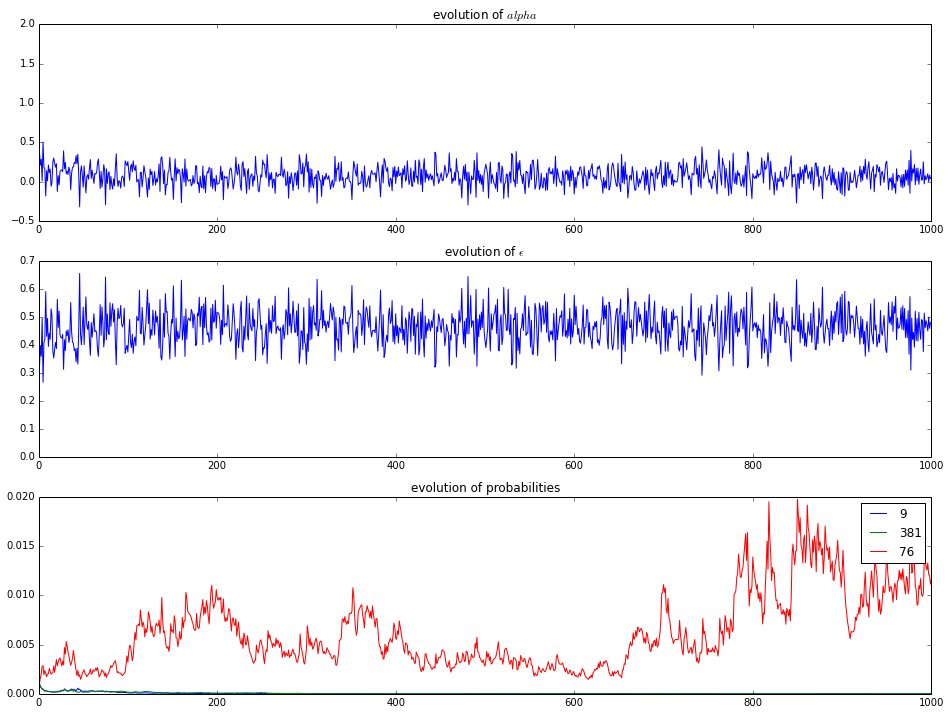

In [52]:
X = np.loadtxt('X.csv', delimiter=',')
y = np.loadtxt('y.csv')
X_test = X[:183, 1:]
y_test = y[:183]
X_train = X[183:, 1:]
y_train = y[183:]
from sklearn.metrics import accuracy_score
B = Bayes()
B.fit(X_train, y_train)
y_predict = B.predict(X_test)
print("Bayes classifier without AdaBoost gets accuracy {}.".format(accuracy_score(y_test, y_predict)))
tests(X_train, y_train, X_test, y_test, Bayes)